# Therapeutic Inertia Nano Sim Test

This notebook is designed to be a nanosim testing different therapeutic inertia parameters in order to see what might be the most effective for use in the CVD sim. 

Models: 
1. Using uncorrelated therapeutic inertia, get some people on meds (one level) + find "ideal" med value from NHANES. Assume everyone in nanosim should be on meds 
2. Implement mixed propensity option 
3. Add in multiple treatment options, create the ladder 
4. Add in SBP levels + effect of treatment

In [1]:
import pandas as pd, numpy as np, os
import scipy.stats, random, matplotlib.pyplot as plt 
import math

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from vivarium import InteractiveContext, Artifact
from pathlib import Path

## Data Loading / Creation

Model 1: 
Ideal medicated level from NHANES and therapeutic inertia value 

Model 2: 
Mixed propensity value 

Model 3: 
Treatment options

Model 4:
SBP exposure and medication effects

In [19]:
inertia = 0.20 ## Means 20% of people DO GET treated and/or tirated on any time step
## Could be easier to change the cutoff instead of the sim level component 

medication_rate = 0.4 #0.597492 # Approx 60% of people who should be on meds are on meds 
sim_prop_rate = 0.5 #Means 50% of the propensity is due to the sim and 50% is random 
churn_rate = 0.05 #Adding a "churn" which is meant to represent people dying + new people needing SBP meds (aging in basically) 

Notes on churn rate: 

We need to include a churn in the model, otherwise with any random component the medication rate will only stabilize at 100%, which we don't want. However, the churn parameter is difficult to conceptualize and quantify. Therefore we completed some sensitivity testing and found that a churn rate between 1-10% gave reasonable results in the nanosim. We think that churn in the full model will fall in this range. 

<Axes: >

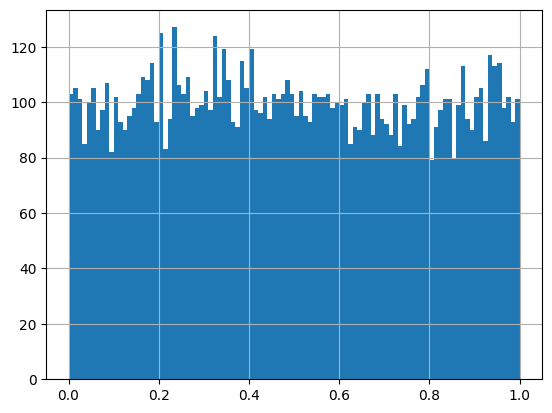

In [16]:
pop = 10_000
sims = pd.DataFrame()
sims['sim_propensity'] = np.random.normal(0, math.sqrt(sim_prop_rate), pop) 
#chosen_idx_high_med = np.random.choice(10_000, replace = False, size=3_000)
#sims['sim_propensity'].iloc[chosen_idx_high_med] = sims['sim_propensity'].iloc[chosen_idx_high_med] + 0.3
#chosen_idx_low_med = np.random.choice(10_000, replace = False, size=3_000)
#sims['sim_propensity'].iloc[chosen_idx_low_med] = sims['sim_propensity'].iloc[chosen_idx_low_med] - 0.3
sims['random_propensity'] = np.random.normal(0, math.sqrt(1-sim_prop_rate), pop) 
sims['total_propensity'] = scipy.stats.norm.cdf(sims['sim_propensity'] + sims['random_propensity'])
sims['total_propensity'].hist(bins=100)
##Looking like this works! 

In [4]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
sim = InteractiveContext(path, setup=False)

In [5]:
sim.configuration.update({
                      'population':
                          {'population_size': 10_000,
                          },
                      }
                    )
sim.setup()

2023-11-27 10:05:41.601 | INFO     | simulation_1-artifact_manager:67 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/artifacts/51-locations/v3-20231019/alabama.hdf.
2023-11-27 10:05:41.605 | INFO     | simulation_1-artifact_manager:68 - Artifact base filter terms are ['draw == 0'].
2023-11-27 10:05:41.607 | INFO     | simulation_1-artifact_manager:69 - Artifact additional filter terms are None.


In [6]:
pop0 = sim.get_population()

In [7]:
data1 = pd.concat([pop0,
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                  ], axis=1)
data1 = data1.loc[(data1.alive == 'alive') & (data1.age > 25)].reset_index()

In [8]:
data1['high_sbp']

0       139.628132
1       138.090383
2       142.957697
3       131.928065
4       131.653876
           ...    
7250    157.515212
7251    105.089652
7252    139.028582
7253    200.000000
7254    111.066676
Name: high_sbp, Length: 7255, dtype: float64

## The Nanosim

Model 1: Sim ID, Time Step, Medication (Yes/No)

In [20]:
def run_nanosim(pop, n_steps):
    final_data = pd.DataFrame()
    final_data['time_step'] = range(n_steps)
    final_data['percent_meds_1'] = range(n_steps)
    final_data['percent_meds_2'] = range(n_steps)
    final_data['percent_meds_3'] = range(n_steps)
    final_data['percent_meds_4'] = range(n_steps)
    final_data['percent_meds_5'] = range(n_steps)
    final_data['percent_meds_6'] = range(n_steps)
    final_data['percent_meds_all'] = range(n_steps)
    
    sims = pd.DataFrame()
    sims['ID'] = range(pop)
    sims['meds'] = 0 
    sims['sim_propensity'] = np.random.normal(0, math.sqrt(sim_prop_rate), pop) 
    sims['original_sbp'] =  data1['high_sbp']
    sims['adjusted_sbp'] =  data1['high_sbp']

    for i in range(n_steps):
        sims['time_step'] = i
        sims['random_propensity'] = np.random.normal(0, math.sqrt(1-sim_prop_rate), pop) 
        sims['total_propensity'] = scipy.stats.norm.cdf(sims['sim_propensity'] + sims['random_propensity'])

        ##Check that this is variance vs standard deviaion 
        ##Check that the uniform looks uniform here 

        #Reset some people to no meds due to churn
        chosen_idx = np.random.choice(pop, int(churn_rate*pop), replace = False)
        sims.iloc[chosen_idx, sims.columns.get_loc('meds')] = 0
        
        #Put people on medication or up their medication 
        sims['meds'] = np.where(sims['meds'] == 6, 6, 
                                np.where(sims['adjusted_sbp'] < 130, sims['meds'], 
                                np.where(sims['total_propensity'] < inertia, sims['meds'] + 1, sims['meds'])))

        ##Lower SBP levels as a result of medication. 
        ##Each additional SBP med level is assumed to decrease SBP by 5 points. This is an oversimplifcation but works on average. 
        sims['adjusted_sbp'] = sims['original_sbp'] - (5*sims['meds'])
        
        #sims['meds'] = np.where(sims['meds'] == 1, 1, np.where(sims['total_propensity'] < inertia, 1, 0))
        
        #Get percent medicated for each time step 
        final_data.iloc[i,1] = len(sims.loc[sims['meds'] == 1])/len(sims.loc[sims['original_sbp'] > 130])
        final_data.iloc[i,2] = len(sims.loc[sims['meds'] == 2])/len(sims.loc[sims['original_sbp'] > 130])
        final_data.iloc[i,3] = len(sims.loc[sims['meds'] == 3])/len(sims.loc[sims['original_sbp'] > 130])
        final_data.iloc[i,4] = len(sims.loc[sims['meds'] == 4])/len(sims.loc[sims['original_sbp'] > 130])
        final_data.iloc[i,5] = len(sims.loc[sims['meds'] == 5])/len(sims.loc[sims['original_sbp'] > 130])
        final_data.iloc[i,6] = len(sims.loc[sims['meds'] == 6])/len(sims.loc[sims['original_sbp'] > 130])
        final_data.iloc[i,7] = len(sims.loc[sims['meds'] != 0])/len(sims.loc[sims['original_sbp'] > 130])
        
    return final_data

In [21]:
test = run_nanosim(1_000, 20)
test

,time_step,percent_meds_1,percent_meds_2,percent_meds_3,percent_meds_4,percent_meds_5,percent_meds_6,percent_meds_all
0,0,0.212885,0.000000,0.000000,0.000000,0.000000,0.000000,0.212885
1,1,0.243697,0.072829,0.000000,0.000000,0.000000,0.000000,0.316527
2,2,0.218487,0.120448,0.028011,0.000000,0.000000,0.000000,0.366947
3,3,0.235294,0.120448,0.050420,0.011204,0.000000,0.000000,0.417367
4,4,0.218487,0.131653,0.070028,0.019608,0.002801,0.000000,0.442577
5,5,0.243697,0.123249,0.072829,0.039216,0.008403,0.000000,0.487395
6,6,0.238095,0.126050,0.072829,0.047619,0.016807,0.005602,0.507003
7,7,0.254902,0.109244,0.084034,0.053221,0.022409,0.011204,0.535014
8,8,0.243697,0.128852,0.067227,0.047619,0.042017,0.016807,0.546218
9,9,0.235294,0.117647,0.072829,0.047619,0.044818,0.028011,0.546218
